# 理解 PLONK（一）：Plonkish Arithmetization


算术化是指把计算转换成数学对象，然后进行零知识证明。 Plonkish 算术化是 Plonk 证明系统特有的算术化方法，在 Plonkish 出现之前，主流的电路表达形式为 R1CS，被 Pinocchio，Groth16，Bulletproofs 等广泛采用。2019 年 Plonk 方案提出了一种看似复古的电路编码方式，但由于 Plonk 方案将多项式的编码应用到了极致，它不再局限于算术电路中的「加法门」和「乘法门」，而是可以支持更灵活的「自定义门」与「查表门」。

我们先回顾一下 R1CS 的电路编码，也是相关介绍最多的算术化方案。然后我们对比引入 Plonkish 编码。

## 算术电路与 R1CS 算术化

一个算术电路包含若干个乘法门与加法门。每一个门都有「两个输入」引脚和一个「输出」引脚，任何一个输出引脚可以被接驳到多个门的输入引脚上。

先看一个非常简单的算术电路：

![img20230414162317](img/img20230414162317.png)

这个电路表示了这样的一个计算：

$$
(x_1 + x_2) \cdot (2\cdot x_3) = out
$$

电路中有4个变量，其中三个变量为输入变量 $(x_1, x_2, x_3)$ ，一个输出变量 $out$，其中还有一个输入为常数，其值为 $2$。

一个电路有两种状态：「空白态」和「运算态」。当输入变量没有具体值的时候，电路处于「空白态」，这时我们只能描述电路引线之间的关系，即电路的结构拓扑。


![](img/img20230414162845.png)

接下来的问题是，我们要先编码电路的「空白态」，即编码各个门的位置，和他们之间引线连接关系。

R1CS 是通过图中的乘法门为中心，用三个「选择子」矩阵来「选择」乘法门的「左输入」、「右输入」、「输出」都分别连接了那些变量。

我们先看看图中最上面的乘法门的左输入，可以用下面的表格来描述：

$$
\begin{array}{|c|c|c|c|c|}
\hline
1 & x_1 & x_2 & x_3 & out \\
\hline
0 & 1 & 1 & 0 & 0 \\
\hline
\end{array}
$$

这个表格只有一行，因此我们可以用一个向量 $U=(0,1,1,0,0)$ 来代替，表示乘法门的左输入连接了两个变量， $x_1$ 和 $x_2$。记住，所有的加法门都会被展开成多个变量的相加（或线性组合）。

再看看其右输入，连接了一个变量 $x_3$ 和一个常数值，等价于连接了 $x_3$ 的两倍，那么右输入的选择子矩阵可以记为 

$$
\begin{array}{|c|c|c|c|c|}
\hline
1 & x_1 & x_2 & x_3 & out \\
\hline
0 & 0 & 0 & 2 & 0 \\
\hline
\end{array}
$$

这里同样可以用一个行向量 $V=(0,0,0,2,0)$ 来表示，其中的 $2$ 即为上图中电路的常数引线。

最后乘法门的输出按照上面的方法可以描述为 $W=(0,0,0,0,1)$，即输出变量为 $out$：

$$
\begin{array}{|c|c|c|c|c|}
\hline
1 & x_1 & x_2 & x_3 & out \\
\hline
0 & 0 & 0 & 0 & 1 \\
\hline
\end{array}
$$

有了三个向量 $(U,V,W)$，我们可以通过一个「内积」等式来约束电路的运算：

$$
\big(U\cdot(1,x_1, x_2,x_3,out)\big) \cdot \big(V\cdot(1,x_1, x_2,x_3,out)\big) = \big(W\cdot(1,x_1, x_2,x_3,out)\big)
$$

这个等式化简之后正好可以得到：

$$
(x_1 + x2) \cdot (2\cdot x_3) = out
$$

如果我们把这几个变量换成赋值向量 $(1,x_1,x_2,x_3,out) = (1,3,4,5,70)$，那么电路的运算可以通过「内积」等式来验证：

$$
(U\cdot(1,3,4,5,70))\cdot(U\cdot(1,3,4,5,70))=W\cdot(1,3,4,5,70)
$$


In [17]:
import numpy as np

# selector matrices
A = np.array([[0, 1, 1, 0, 0]])
B = np.array([[0, 0, 0, 2, 0]])
C = np.array([[0, 0, 0, 0, 1]])

# assignments vector: (1, x1, x2, x3, out)
assignments = [1, 3, 4, 5, 70]

# calculate inner product, which is element-wise multiplication
inner_product_c = C.dot(assignments)
inner_product_a_b = A.dot(assignments) * B.dot(assignments)

print("Output:")
print(inner_product_c)
print(inner_product_a_b)

assert np.array_equal(inner_product_c, inner_product_a_b)

print("Checks pass!") # Will print this, all checks will pass

Output:
[70]
[70]
Checks pass!


而一个错误的赋值向量，比如 $(1,3,4,\fbox{0},70)$ ，则不满足「内积等式」：

$$
(U\cdot(1,3,4,\fbox{0},70))\cdot(U\cdot(1,3,4,\fbox{0},70))\neq W\cdot(1,3,4,\fbox{0},70)
$$

左边运算结果为 $0$，右边运算结果为 $70$。当然，我们可以验证 $(1,3,4,0,0)$ 也是一组合法（满足电路约束）的赋值。

In [18]:
import numpy as np

# selector matrices
A = np.array([[0, 1, 1, 0, 0]])
B = np.array([[0, 0, 0, 2, 0]])
C = np.array([[0, 0, 0, 0, 1]])

# assignments vector: (1, x1, x2, x3, out)
assignments = [1, 3, 4, 0, 70]

# calculate inner product, which is element-wise multiplication
inner_product_c = C.dot(assignments)
inner_product_a_b = A.dot(assignments) * B.dot(assignments)

print("Output:")
print(inner_product_c)
print(inner_product_a_b)

assert not np.array_equal(inner_product_c, inner_product_a_b)

print("You have the wrong assignments!")

Output:
[70]
[0]
You have the wrong assignments!


并不是任何一个电路都存在赋值向量。凡是存在合法的赋值向量的电路，被称为可被满足的电路。判断一个电路是否可被满足，是一个 NP-Complete 问题，也是一个 NP 困难问题。

这里例子中的两个乘法门并不相同，上面的乘法门是左右输入中都含有变量，而下面的乘法门只有一边的输入为变量，另一边为常数。对于后者这类「常数乘法门」，后续我们也把他们看作为特殊的「加法门」，如下图所示，左边电路右下的乘法门等价于右边电路的右下加法门。



![](img/img20230423133455.png)



那么如果一个电路含有两个以上的乘法门，我们就不能用 $U,V,W$ 三个向量之间的内积关系来表示运算，而需要构造「三个矩阵」的运算关系。

### 多个乘法门

比如下图所示电路，有两个乘法门，他们的左右输入都涉及到变量。

![c](img/img20230414170601.png)

这个电路表示了这样的一个计算：

$$
(x_1 + x2) \cdot (x3 \cdot x4) = out
$$

我们以**乘法门**为基准，对电路进行编码。第一步将电路中的乘法门依次编号（无所谓编码顺序，只要前后保持一致）。图中的两个乘法门编码为 `#1` 与 `#2`。

然后我们需要为每一个乘法门的中间值引线也给出变量名：比如四个输入变量被记为 $x_1, x_2, x_3, x_4$，其中 $x_5$ 为第二个乘法门的输出，同时作为第一个乘法门的右输入。而 $out$ 为第一个乘法门的输出。于是我们可以得到一个关于变量名的向量：

$$
(x_1, x_2, x_3, x_4, x_5, out)
$$

该电路的「空白态」可以用下面的三个矩阵来编码：

$$
U, V, W \in \mathbb{F}^{n\times m}
$$

其中 $n$ 为乘法门的数量，而 $m$ 大致为引线的数量。每一个矩阵的第 $i$ 行「选择」了第 $i$ 个乘法门的输入输出变量。比如我们定义电路的左输入矩阵  $U$ ：

$$
\begin{array}{|c|c|c|c|c|}
\hline
x_1 & x_2 & x_3 & x_4 & x_5 & out & \texttt{i} \\
\hline
1 & 1 & 0 & 0 & 0 & 0 & \texttt{1}\\
\hline
0 & 0 & 1 & 0 & 0 & 0 & \texttt{2}\\
\hline
\end{array}
$$

其中第一个乘法门的左输入为 $(x_1+x_2)$， 第二个乘法门的左输入为 $x_3$。右输入矩阵 $V$ 定义为：

$$
\begin{array}{|c|c|c|c|c|}
\hline
x_1 & x_2 & x_3 & x_4 & x_5 & out &\texttt{i}\\
\hline
0 & 0 & 0 & 0 & 1 & 0 & \texttt{1}\\
\hline
0 & 0 & 0 & 1 & 0 & 0 & \texttt{2}\\
\hline
\end{array}
$$

其中1号门的右输入为 $x_5$，第二个乘法门的右输入为 $x_4$。最后定义输出矩阵 $W$：

$$
\begin{array}{|c|c|c|c|c|}
\hline
x_1 & x_2 & x_3 & x_4 & x_5 & out & \texttt{i}\\
\hline
0 & 0 & 0 & 0 & 0 & 1 & \texttt{1}\\
\hline
0 & 0 & 0 & 0 & 1 & 0 & \texttt{2}\\
\hline
\end{array}
$$

我们把所有的引线赋值看作为一个向量： $\vec{a}$ （这里用字母 $a$，取自 Assignments 首字母）

在上面的例子中，「赋值向量」为

$$
\vec{a} = (x_1, x_2, x_3,x_4,x_5,out)
$$

于是我们可以轻易地检验下面的等式

$$
(U \cdot \vec{a}) \circ (V \cdot \vec{a}) = (W \cdot\vec{a})
$$

其中符号 $\circ$ 为 Hadamard Product，表示「按位乘法」。展开上面的按位乘法等式，我们可以得到这个电路的运算过程：

$$
\left[
\begin{array}{c}
x_1 + x_2 \\
x_3 \\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
x_5 \\
x_4 \\
\end{array}
\right]=
\left[
\begin{array}{c}
out \\
x_5 \\
\end{array}
\right]
$$

请注意，通常「赋值向量」中需要一个固定赋值为 $1$ 的变量，这是为了处理加法门中的常量输入。



In [19]:
import numpy as np

# selector matrices
A = np.array([[1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])
B = np.array([[0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0]])
C = np.array([[0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0]])

# assignments vector: (x1, x2, x3, x4, x5, out)
assignments = [3, 4, 5, 2, 10, 70]

# calculate inner product, which is element-wise multiplication
inner_product_c = C.dot(assignments)
inner_product_a_b = A.dot(assignments) * B.dot(assignments)

print("Output:")

print(inner_product_c)
print(inner_product_a_b)

assert np.array_equal(inner_product_c, inner_product_a_b)

print("Checks pass!") # Will print this, all checks will pass

Output:
[70 10]
[70 10]
Checks pass!


多个乘法门练习

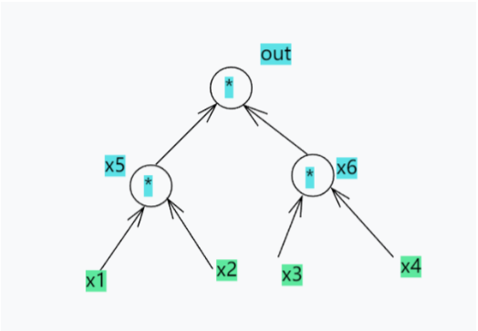

这个电路展示了这样的一个计算：

$$
(x_1 \cdot x2) \cdot (x3 \cdot x4) = out
$$

定义电路的左输入矩阵$U$：

$$
\begin{array}{c|c|c|c|c|c|c|c}
\hline
x_1 & x_2 & x_3 & x_4 & x_5 & x_6 & out & \texttt{i} \\
\hline
0 & 0 & 0 & 0 & 1 & 0 & 0 & \texttt{1}\\
\hline
1 & 0 & 0 & 0 & 0 & 0 & 0 & \texttt{2}\\
\hline
0 & 0 & 1 & 0 & 0 & 0 & 0 & \texttt{3}\\
\hline
\end{array}
$$

定义电路的右输入矩阵$V$：

$$
\begin{array}{c|c|c|c|c|c|c|c}
\hline
x_1 & x_2 & x_3 & x_4 & x_5 & x_6 & out & \texttt{i} \\
\hline
0 & 0 & 0 & 0 & 0 & 1 & 0 & \texttt{1}\\
\hline
0 & 1 & 0 & 0 & 0 & 0 & 0 & \texttt{2}\\
\hline
0 & 0 & 0 & 1 & 0 & 0 & 0 & \texttt{3}\\
\hline
\end{array}
$$


最后定义输出矩阵$W$:

$$
\begin{array}{c|c|c|c|c|c|c|c}
\hline
x_1 & x_2 & x_3 & x_4 & x_5 & x_6 & out & \texttt{i} \\
\hline
0 & 0 & 0 & 0 & 0 & 0 & 1 & \texttt{1}\\
\hline
0 & 0 & 0 & 0 & 1 & 0 & 0 & \texttt{2}\\
\hline
0 & 0 & 0 & 0 & 0 & 1 & 0 & \texttt{3}\\
\hline
\end{array}
$$




In [2]:
import numpy as np

# selector matrices
A = np.array([[0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, 0]])
#B = np.array([[0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, 0]])
B = np.array([[0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 1, 0, 0, 0]])
C = np.array([[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0],[0, 0, 0, 0, 0, 1, 0]])

# assignments vector: (x1, x2, x3, x4, x5,x6, out)
assignments = [1, 2, 3, 4, 2, 12, 24]

# calculate inner product, which is element-wise multiplication
inner_product_c = C.dot(assignments)
inner_product_a_b = A.dot(assignments) * B.dot(assignments)

print("Output:")

print(inner_product_c)
print(inner_product_a_b)

assert np.array_equal(inner_product_c, inner_product_a_b)

print("Checks pass!") # Will print this, all checks will pass

Output:
[24  2 12]
[24  2 12]
Checks pass!


### 优缺点

由于 R1CS 编码以乘法门为中心，于是电路中的加法门并不会增加 $U, V, W$ 矩阵的行数，因而对 Prover 的性能影响不大。R1CS 电路的编码清晰简单，利于在其上构造各种 SNARK 方案。

在 2019 年 Plonk 论文中的编码方案同时需要编码加法门与乘法门，看起来因此会增加约束的数量，降低 Proving 性能。但 Plonk 团队随后陆续引入了除乘法与加法外的运算门，比如实现范围检查的门，实现异或运算的门等等。不仅如此，Plonk 支持任何其输入输出满足多项式关系的门，即 Custom Gate，还有适用于实现 RAM 的状态转换门等，随着查表门的提出，Plonk 方案逐步成为许多应用的首选方案，其编码方式也有了一个专门的名词：Plonkish。

## Plonkish 算术门

回看下例子电路，我们把三个门全都编号， $\texttt{1},\texttt{2},\texttt{3}$，同时把加法门的输出值也标记为变量 $x_6$。

![](img/img20230414202348.png)

显然，上面的电路满足三个约束：

- $x_1 + x_2 =x_6$
- $x_3\cdot x_4 = x_5$
- $x_6 \cdot x_5 = out$

我们定义一个矩阵 $W\in\mathbb{F}^{n\times 3}$ 来表示约束（ $n$ 为算术门的数量）：

$$
\begin{array}{c|c|c|c|}
\texttt{i} & w_a & w_b & w_c  \\
\hline
\texttt{1} & x_6 & x_5 & out \\
\texttt{2} & x_1 & x_2 & x_6 \\
\texttt{3} & x_3 & x_4 & x_5 \\
\end{array}
$$

为了区分加法和乘法，我们再定一个向量 $Q\in\mathbb{F}^{n\times5}$ 来表示运算符

$$
\begin{array}{c|c|c|c|}
\texttt{i}  & q_L & q_R & q_M & q_C & q_O  \\
\hline
\texttt{1} & 0 & 0 & 1 & 0& 1 \\
\texttt{2} & 1 & 1 & 0 & 0& 1 \\
\texttt{3} & 0 & 0 & 1 & 0& 1 \\
\end{array}
$$

于是我们可以通过下面的等式来表示三个约束：

$$
q_L \circ w_a + q_R \circ w_b + q_M\circ(w_a\cdot w_b) + q_C -  q_O\circ w_c = 0
$$

如果把上面的等式代入并展开，我们可以得到下面的约束等式：

$$
\left[
\begin{array}{c}
0\\
1 \\
0\\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
x_6 \\
x_1 \\
x_5\\
\end{array}
\right]
+
\left[
\begin{array}{c}
0\\
1 \\
0\\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
x_5 \\
x_2 \\
x_4\\
\end{array}
\right]
+
\left[
\begin{array}{c}
1\\
0 \\
1\\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
x_6\cdot x_5 \\
x_1\cdot x_2 \\
x_3\cdot x_4\\
\end{array}
\right]=\left[
\begin{array}{c}
1\\
1 \\
1\\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
out \\
x_6 \\
x_5\\
\end{array}
\right]
$$

化简后得：

$$
\left[
\begin{array}{c}
0 \\
x_1 \\
0\\
\end{array}
\right]
+
\left[
\begin{array}{c}
0 \\
x_2 \\
0\\
\end{array}
\right]
+
\left[
\begin{array}{c}
x_6\cdot x_5 \\
0 \\
x_3\cdot x_4\\
\end{array}
\right]=\left[
\begin{array}{c}
out \\
x_6 \\
x_5\\
\end{array}
\right]
$$

这正好是三个算术门的计算约束。



将矩阵 $W\in\mathbb{F}^{n\times 3}$ 填入响应的值，以满足电路各个门的约束：

$$
\begin{array}{c|c|c|c|}
\texttt{i} & w_a & w_b & w_c  \\
\hline
\texttt{1} & 3 & 33 & 99 \\
\texttt{2} & 1 & 2 & 3 \\
\texttt{3} & 3 & 11 & 33 \\
\end{array}
$$

然后用代码验证:

In [20]:
import numpy as np

# Q
q_L = np.array([0, 1, 0])
q_R = np.array([0, 1, 0])
q_M = np.array([1, 0, 1])
q_C = np.array([0, 0, 0])
q_O = np.array([1, 1, 1])

w_a = np.array([3, 1, 3])
w_b = np.array([33, 2, 11])
w_c = np.array([99, 3, 33])

constraints = q_L.dot(w_a) + q_R.dot(w_b) + q_M.dot(w_a * w_b) + q_C.dot(np.array([1, 1, 1])) - q_O.dot(w_c)

assert constraints == 0

做一个练习。

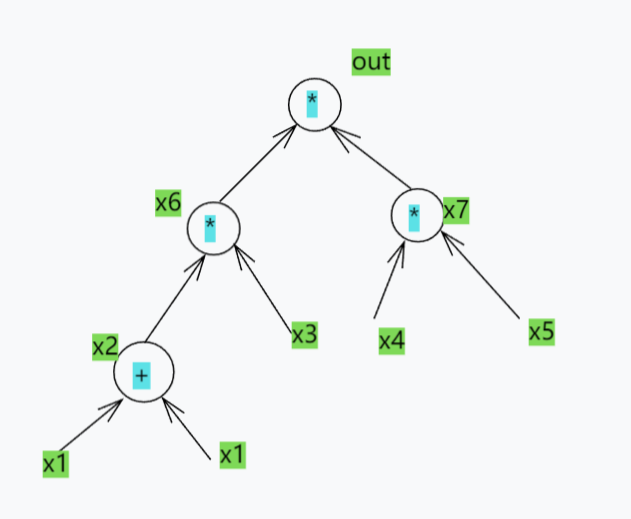

这个电路满足4个约束：

- $x_1 + x_1 =x_2$
- $x_2\cdot x_3 = x_6$
- $x_4 \cdot x_5 = x_7$
- $x_6 \cdot x_7 = out$

先写出来约束矩阵

$$
\begin{array}{c|c|c|c|}
\texttt{i} & w_l & w_r & w_0  \\
\hline
\texttt{1} & x_1 & x_1 & x_2 \\
\texttt{2} & x_2 & x_3 & x_6 \\
\texttt{3} & x_4 & x_5 & x_7 \\
\texttt{4} & x_6 & x_7 & out \\
\end{array}
$$

接下来定义区分乘法和加法的向量 $Q\in\mathbb{F}^{n\times5}$ 来表示运算符

$$
\begin{array}{c|c|c|c|}
\texttt{i}  & q_L & q_R & q_M & q_C & q_O  \\
\hline
\texttt{1} & 1 & 1 & 0 & 0& 1 \\
\texttt{2} & 0 & 0 & 1 & 0& 1 \\
\texttt{3} & 0 & 0 & 1 & 0& 1 \\
\texttt{4} & 0 & 0 & 1 & 0& 1 \\
\end{array}
$$

这样就可以通过下面的等式来表示四个约束：

$$
q_L \circ w_a + q_R \circ w_b + q_M\circ(w_a\cdot w_b) + q_C -  q_O\circ w_c = 0
$$


如果把上面的等式代入并展开，我们可以得到下面的约束等式：

$$
\left[
\begin{array}{c}
1\\
0 \\
0\\
0\\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
x_1 \\
x_2 \\
x_4\\
x_6\\
\end{array}
\right]
+
\left[
\begin{array}{c}
1\\
0 \\
0\\
0\\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
x_1 \\
x_3 \\
x_5\\
x_7\\
\end{array}
\right]
+
\left[
\begin{array}{c}
0\\
1 \\
1\\
1\\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
x_1\cdot x_1 \\
x_2\cdot x_3 \\
x_4\cdot x_5\\
x_6\cdot x_7\\
\end{array}
\right]=\left[
\begin{array}{c}
1\\
1 \\
1\\
1\\
\end{array}
\right]
\circ
\left[
\begin{array}{c}
x_2 \\
x_6 \\
x_7\\
out\\
\end{array}
\right]
$$

化简后得：

$$
\left[
\begin{array}{c}
x_1\\
0 \\
0\\
0\\
\end{array}
\right]
+
\left[
\begin{array}{c}
x_1 \\
0 \\
0 \\
0\\
\end{array}
\right]
+
\left[
\begin{array}{c}
0 \\
x_2\cdot x_3 \\

x_4\cdot x_5\\
x_6\cdot x_7\\
\end{array}
\right]=\left[
\begin{array}{c}
x_2 \\
x_6 \\
x_7\\
out \\
\end{array}
\right]
$$

这正好是四个算术门的计算约束。


将矩阵 $W\in\mathbb{F}^{n\times 4}$ 填入响应的值，以满足电路各个门的约束：

$$
\begin{array}{c|c|c|c|}
\texttt{i} & w_l & w_r & w_o  \\
\hline
\texttt{1} & 1 & 1 & 2 \\
\texttt{2} & 2 & 3 & 6 \\
\texttt{3} & 4 & 5 & 20 \\
\texttt{4} & 6 & 20 & 120 \\
\end{array}
$$

然后用代码验证:

In [2]:
import numpy as np

# Q
q_L = np.array([1, 0, 0, 0])
q_R = np.array([1, 0, 0, 0])
q_M = np.array([0, 1, 1, 1])
q_C = np.array([0, 0, 0, 0])
q_O = np.array([1, 1, 1, 1])

w_l = np.array([1, 2, 4, 6])
w_r = np.array([1, 3, 5, 20])
w_o = np.array([2, 6, 20,120])

constraints = q_L.dot(w_l) + q_R.dot(w_r) + q_M.dot(w_l * w_r) + q_C.dot(np.array([1, 1, 1, 1])) - q_O.dot(w_o)

assert constraints == 0

总结下，Plonkish 需要一个矩阵 $Q$ 来描述电路空白态，而所有的赋值则写入了 $W$ 矩阵。对于 Prover 和 Verifier 的交换协议， $W$ 是 Prover 的 witness，属于秘密知识，对 Verifier 保密， $Q$ 矩阵代表了一个实现双方约定共识的电路描述。

不过仅仅有 $Q$ 矩阵是不足以精确描述上面的例子电路。

## 复制约束

比较下面两个电路，它们的 $Q$ 矩阵完全相同，但它们却完全不同。

![](img/img20230414205219.png)

两个电路的区别在于 $x_5, x_6$ 是否被接入了 `#1` 号门。如果让 Prover 直接把电路赋值填入 $W$ 表格，一个「诚实的」Prover 会在 $w_{a,1}$ 和 $w_{c,2}$ 两个位置填上相同的值；而一个「恶意的」Prover 完全可以填上不同的值。如果恶意 Prover 在 $w_{b,1}$ 和 $w_{c,3}$ 也填入不同的值，那么实际上 Prover 证明的是上图右边的电路，而非是和 Verifier 共识过的电路（左边)。

$$
\begin{array}{c|c|c|c|}
i & w_a & w_b & w_c  \\
\hline
1 & \boxed{x_6} & \underline{x_5} & out \\
2 & x_1 & x_2 & \boxed{x_6} \\
3 & x_3 & x_4 & \underline{x_5} \\
\end{array}
$$

举例来看一下：

In [4]:
import numpy as np

# Q
q_L = np.array([0, 1, 0])
q_R = np.array([0, 1, 0])
q_M = np.array([1, 0, 1])
q_C = np.array([0, 0, 0])
q_O = np.array([1, 1, 1])

w_a = np.array([3, 1, 3])
w_b = np.array([22, 2, 11]) #replace 33 with 22 
w_c = np.array([66, 3, 33]) #replace 99 with 66; only satisfies the constraints 3*22=66; 1+2=3;and 3*11=33 

constraints = q_L.dot(w_a) + q_R.dot(w_b) + q_M.dot(w_a * w_b) + q_C.dot(np.array([1, 1, 1])) - q_O.dot(w_c)

assert constraints == 0

In [5]:
#如果增加输出约束，也即输出一定是99；prover也能轻松构造合适的w矩阵 通过验证
import numpy as np

# Q
q_L = np.array([0, 1, 0])
q_R = np.array([0, 1, 0])
q_M = np.array([1, 0, 1])
q_C = np.array([0, 0, 0])
q_O = np.array([1, 1, 1])

w_a = np.array([9, 1, 3])
w_b = np.array([11, 2, 11])  
w_c = np.array([99, 3, 33]) 

constraints = q_L.dot(w_a) + q_R.dot(w_b) + q_M.dot(w_a * w_b) + q_C.dot(np.array([1, 1, 1])) - q_O.dot(w_c)

assert constraints == 0

因此，我们需要增加新的约束，强制要求右边电路图中 $x_6=x_7$ 和 $x_5=x_8$。这等价于我们要求 Prover 把同一个变量填入表格多个位置时，**必须填入相等的值**。

这就需要一类新的约束——「拷贝约束」，即 Copy Constraint。Plonk 采用「置换证明」保证 $W$ 表格中多个位置上的值满足拷贝关系。我们继续用上面这个电路图的案例来说明其基本思路：

设想我们把 $W$ 表格中的所有位置索引排成一个向量：

$$
\sigma_0=(\boxed{w_{a,1}}, w_{a,2}, w_{a,3}, \underline{w_{b,1}}, w_{b,2}, w_{b,3}, w_{c,1}, \boxed{w_{c,2}}, \underline{w_{c,3}})
$$

然后把应该相等的两个位置互换，比如上图中要求 $w_{a,1}=w_{c,2}$ 和 $w_{b,1}=w_{c,3}$ 。于是我们得到了下面的位置向量：

$$
\sigma=(\boxed{w_{c,2}}, w_{a,2}, w_{a,3}, \underline{w_{c,3}}, w_{b,2}, w_{b,3}, w_{c,1}, \boxed{w_{a,1}}, \underline{w_{b,1}})
$$

然后我们要求 Prover 证明： **$W$ 表格按照上面的置换之后，仍然等于自身**。置换前后的相等性可以保证 Prover 无法作弊。

再来一个例子，当约束一个向量中有三个（或多个）位置上的值必须相同时，只需要把这三个（或多个）位置的值进行循环移位（左移位或者右移位），然后证明移位后的向量与原向量相等即可。比如：

$$
A = (b_1, b_2, \underline{a_1}, b_3, \underline{a_2}, b_4, \underline{a_3})
$$

如果要证明 $a_1=a_2=a_3$，那么只需要证明：

$$
A' =  (b_1, b_2, \underline{a_3}, b_3, \underline{a_1}, b_2, \underline{a_2}) \overset{?}{=} A
$$

在经过置换的向量 $A'$ 中， $a_1, a_2, a_3$ 依次右移交换，即 $a_1$ 放到了原来 $a_2$ 的位置，而 $a_2$ 放到了 $a_3$ 的位置， $a_3$ 则放到了 $a_1$ 的位置。

如果 $A'=A$ ，那么 $A'$ 和 $A$ 所有对应位置上的值都应该相等，可得： $a_1=a_3$， $a_2=a_1$， $a_3=a_2$，即 $a_1=a_2=a_3$。这个方法可以适用于任意数量的等价关系。（后续证明两个向量相等的方法请见下章）

那么如何描述电路赋值表格中的交换呢？我们只需要记录 $\sigma$ 向量即可，当然 $\sigma$ 向量也可以写成表格的形式：

$$
\begin{array}{c|c|c|c|}
i & \sigma_a & \sigma_b & \sigma_c  \\
\hline
1 & \boxed{w_{c,2}} & \underline{w_{c,3}}& w_{c,1} \\
2 & w_{a,2} & w_{b,2} & \boxed{w_{a,1}} \\
3 & w_{a,3} & w_{b,3} & \underline{w_{b,1}} \\
\end{array}
$$

加上 $\sigma$ ，空白电路可以描述为 $(Q,\sigma)$ ，电路的赋值为 $W$

$$
\mathsf{Plonkish}_0 \triangleq (Q, \sigma; W)
$$

## 再比较

R1CS 的 $(U,V,W)$ 表格的宽度与引线的数量有关，行数跟乘法门数量有关。这个构造相当于把算术电路看成是仅有乘法门构成，但每个门有多个输入引脚（最多为所有引线的数量）。而 Plonkish 则是同等对待加法门与乘法门，并且因为输入引脚只有两个， 所以 $W$ 表格的宽度固定，仅有三列（如果要支持高级的计算门，表格可以扩展到更多列）。这一特性是 Plonk 可以利用 Permutation Argument 实现拷贝约束的前提。

> ..., and thus our linear contraints are just wiring constraints that can be reduced to a permutation check. 

按照 Plonk 论文的统计，一般情况下，算术电路中加法门的数量是乘法门的两倍。如果这样看来， $W$ 表格的长度会三倍于 R1CS 的矩阵。但这个让步会带来更多的算术化灵活度。

## 电路验证协议框架

有了电路空白结构的描述和赋值，我们可以大致描述下 Plonk 的协议框架。

首先 Prover 和 Verifier 会对一个共同的电路进行共识， $(Q,\sigma)$ 。 假设电路的公开输出为 $out=99$，而 $(x_1,x_2,x_3,x_4)$ 为秘密输入。

Prover 填写 $W$ 矩阵（Verifier 不可见）：

$$
\begin{array}{c|c|c|c|}
i & w_a & w_b & w_c  \\
\hline
1 & \boxed{x_6} & \underline{x_5} & [out] \\
2 & x_1 & x_2 & \boxed{x_6} \\
3 & x_3 & x_4 & \underline{x_5} \\
4 & 0 & 0 & [out] \\
\end{array}
$$

其中增加的第四行是为了增加一个额外的算术约束： $out=99$ ，把 $out$ 值显示地表示在 $Q$ 矩阵中。

相应的那么 Prover 和 Verifier 共识的 $Q$ 矩阵为

$$
\begin{array}{c|c|c|c|}
i & q_L & q_R & q_M & q_C & q_O  \\
\hline
1 & 0 & 0 & 1 & 0& 1 \\
2 & 1 & 1 & 0 & 0& 1 \\
3 & 0 & 0 & 1 & 0& 1 \\
4 & 0 & 0 & 0 & 99& 1 \\
\end{array}
$$

其中第四行约束，保证 $out=99$，可以把 $(q_L=0, q_R=0,q_M=0,q_C=99,q_O=1)$ 代入下面的算术约束，可得 $99-w_c = 0$ ，即 $w_{c,4}=99$ 。

$$
q_L \circ w_a + q_R \circ w_b + q_M\circ(w_a\cdot w_b) + q_C -  q_O\circ w_c = 0
$$

为了保证第一行的 $w_c$ 也必须为 $99$，这就需要在 $\sigma$ 矩阵中添加额外的一条拷贝约束：让 $out$ 变量的位置 $(w_{c,1})$ 与  第四行的输出 $w_{c,4}$ 交换对调：

$$
\begin{array}{c|c|c|c|}
i & \sigma_a & \sigma_b & \sigma_c  \\
\hline
1 & \boxed{w_{c,2}} & \underline{w_{c,3}} & [w_{c,4}] \\
2 & w_{a,2} & w_{b,2} & \boxed{w_{a,1}} \\
3 & w_{a,3} & w_{b,3} & \underline{w_{b,1}} \\
4 & w_{a,4} & w_{b,4} & [w_{c,1}]\\
\end{array}
$$

如果 Prover 是诚实的，那么对于 $i\in(1,2,3,4)$，下面的算术约束等式成立：

$$
q_{L,i} \circ w_{a,i} + q_{R,i} \circ w_{b,i} + q_{M,i}\circ(w_{a,i}\cdot w_{b,i}) + q_{C,i} -  q_{O,i}\circ w_{c,i} = 0
$$


假设 W 矩阵为:
$$
\begin{array}{c|c|c|c|}
i & w_a & w_b & w_c  \\
\hline
1 & \boxed{3} & \underline{33} & [99] \\
2 & 1 & 2 & \boxed{3} \\
3 & 3 & 11 & \underline{33} \\
4 & 0 & 0 & [99] \\
\end{array}
$$

代码验证如下。

In [21]:
import numpy as np

# Q
q_L = np.array([0, 1, 0, 0])
q_R = np.array([0, 1, 0, 0])
q_M = np.array([1, 0, 1, 0])
q_C = np.array([0, 0, 0, 99])
q_O = np.array([1, 1, 1, 1])

w_a = np.array([3, 1, 3, 0])
w_b = np.array([33, 2, 11, 0])
w_c = np.array([99, 3, 33, 99])

constraints = q_L.dot(w_a) + q_R.dot(w_b) + q_M.dot(w_a * w_b) + q_C.dot(np.array([1, 1, 1, 1])) - q_O.dot(w_c)
print("Output:")
print ("constraints: ", constraints)
assert constraints == 0

# or

for i in range(0,4):
    constraint = q_L[i] * w_a[i] + q_R[i] * w_b[i] + q_M[i] * w_a[i] * w_b[i] + q_C[i] - q_O[i] * w_c[i]
    print("constraint", i, ":", constraint)
    assert constraint == 0

Output:
constraints:  0
constraint 0 : 0
constraint 1 : 0
constraint 2 : 0
constraint 3 : 0


验证协议的大概思路如下：

协议开始：Prover 如实填写 $W$ 表格，然后把 $W$ 表格的每一列进行编码，并进行多项式编码，并把编码后的结果发送给 Verifier

协议验证阶段：Verifier 与 Prover 通过进一步的交互，验证下面的等式是否成立：

$$
q_{L}(X) \cdot w_{a}(X) + q_{R}(X) \cdot w_{b}(X) + q_{M}(X)\cdot(w_{a}(X)\cdot w_{b}(X)) + q_{C}(X) -  q_{O}(X)\cdot w_{c}(X) \overset{?}{=} 0
$$

下面的代码展示了如何验证上面等式成立的过程，其中涉及到多项式（Lagrange 插值）和有限域的知识，其中多项式的知识可以参考下一节的讲解。

In [22]:
import numpy as np
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

# Given two 1-D arrays x and y
# Returns the Lagrange interpolating polynomial through the points (x, y).
def interpolate_with_lagrange(x, y):
    coef = lagrange(x, y).coef
    # Reverse coefficients due to they have different constructor parameter
    return Polynomial(coef[::-1])

# Q
q_L = np.array([0, 1, 0, 0])
q_R = np.array([0, 1, 0, 0])
q_M = np.array([1, 0, 1, 0])
q_C = np.array([0, 0, 0, 99])
q_O = np.array([1, 1, 1, 1])

w_a = np.array([3, 1, 3, 0])
w_b = np.array([33, 2, 11, 0])
w_c = np.array([99, 3, 33, 99])

# [0, 1, 2, 3]
x_points = range(0, 4)

# do the interpolation, return polynomial
q_L_x = interpolate_with_lagrange(x_points, q_L)
# Evaluate polynomial with x_points
evals = q_L_x(x_points)

print("Output:")
print("q_L Lagrange interpolating polynomial: ", q_L_x)
print("Evaluate q_L polynomial should get original values: ", evals)

# Check the equality with q_L
assert np.array_equal(evals, q_L)

q_R_x = interpolate_with_lagrange(x_points, q_R)
q_M_x = interpolate_with_lagrange(x_points, q_M)
q_C_x = interpolate_with_lagrange(x_points, q_C)
q_O_x = interpolate_with_lagrange(x_points, q_O)
w_a_x = interpolate_with_lagrange(x_points, w_a)
w_b_x = interpolate_with_lagrange(x_points, w_b)
w_c_x = interpolate_with_lagrange(x_points, w_c)

print("q_M_x: ", q_M_x)
print("q_M_x(x_points): ", q_M_x(x_points))
assert np.array_equal(q_R_x(x_points), q_R)
assert np.array_equal(q_M_x(x_points), q_M)
assert np.array_equal(q_C_x(x_points), q_C)
assert np.array_equal(q_O_x(x_points), q_O)
assert np.array_equal(w_a_x(x_points), w_a)
assert np.array_equal(w_b_x(x_points), w_b)
assert np.array_equal(w_c_x(x_points), w_c)


Output:
q_L Lagrange interpolating polynomial:  0.0 + 3.0 x - 2.5 x**2 + 0.5 x**3
Evaluate q_L polynomial should get original values:  [0. 1. 0. 0.]
q_M_x:  1.0 - 3.33333333 x + 3.0 x**2 - 0.66666667 x**3
q_M_x(x_points):  [1.0000000e+00 4.4408921e-16 1.0000000e+00 8.8817842e-16]


AssertionError: 

上面的代码运行到这一行会报错:
```python
assert np.array_equal(q_M_x(x_points), q_M)
```
检查打印的log 会发现 q_M_x(x_points) 求值得到的是：
q_M_x(x_points): `[1.00000000e+00 3.55271368e-15 1.00000000e+00 7.10542736e-15]`

而是不是我们期望的 `[1, 0, 1, 0]`。

这是因为我们目前的多项式是在实数域通过 Lagrange 插值得到的，从上面打印出来的值可以看到，形式是:
q_M_x: `1.0 - 3.33333333·x + 3.0·x² - 0.66666667·x³`

这里的系数是小数，所以将 x 值(`[0, 1, 2, 3]`)带入多项式求值得到的结果也是小数，不等于我们期望的原始值 `[1, 0, 1, 0]`。

而如果用分数来表达，实际上得到的多项式是: q_M_x: `q_M_x:  1.0 - 10/3·x + 3·x² - 2/3·x³`

将 x 值(`[0, 1, 2, 3]`)带入多项式求值得到的结果是等于我们期望的原始值 `[1, 0, 1, 0]`。

但这里计算机不能用分数来表示多项式。

如何解决这个问题呢？

答案是将实数域的计算映射到有限域的计算。在有限域内做多项式的相关计算，参考下面的代码实现。

In [10]:
import numpy as np
import galois

GF101 = galois.GF(101)

# Given two 1-D arrays x and y
# Returns the Lagrange interpolating polynomial through the points (x, y).
def lagrange_poly_in_finite_field(x, y):
    return galois.lagrange_poly(GF101(x), GF101(y))

# Q
#q_L = [0, 1, 0, 0]
q_L = [0, 0, 0, 1]
q_R = [0, 1, 0, 0]
q_M = [1, 0, 1, 0]
q_C = [0, 0, 0, 99]
q_O = [1, 1, 1, 1]

w_a =[3, 1, 3, 0]
w_b =[33, 2, 11, 0]
w_c =[99, 3, 33, 99]

x_points = [0, 1, 2, 3]

# do the interpolation, return polynomial
q_L_x = lagrange_poly_in_finite_field(x_points, q_L)
q_R_x = lagrange_poly_in_finite_field(x_points, q_R)
q_M_x = lagrange_poly_in_finite_field(x_points, q_M)
q_C_x = lagrange_poly_in_finite_field(x_points, q_C)
q_O_x = lagrange_poly_in_finite_field(x_points, q_O)
w_a_x = lagrange_poly_in_finite_field(x_points, w_a)
w_b_x = lagrange_poly_in_finite_field(x_points, w_b)
w_c_x = lagrange_poly_in_finite_field(x_points, w_c)

print("Output:")
print("q_L_x: ", q_L_x)
print("w_a_x:",w_a_x)

print("q_L_x evaluations: ", q_L_x(x_points))
print("q_R_x evaluations: ", q_R_x(x_points))
print("q_M_x evaluations: ", q_M_x(x_points))
print("q_C_x evaluations: ", q_C_x(x_points))
print("q_O_x evaluations: ", q_O_x(x_points))
print("w_a_x evaluations: ", w_a_x(x_points))
print("w_b_x evaluations: ", w_b_x(x_points))
print("w_c_x evaluations: ", w_c_x(x_points))

# Check the equality with original values
assert np.array_equal(q_L_x(x_points), q_L)
assert np.array_equal(q_R_x(x_points), q_R)
assert np.array_equal(q_M_x(x_points), q_M)
assert np.array_equal(q_C_x(x_points), q_C)
assert np.array_equal(q_O_x(x_points), q_O)
assert np.array_equal(w_a_x(x_points), w_a)
assert np.array_equal(w_b_x(x_points), w_b)
assert np.array_equal(w_c_x(x_points), w_c)



final_check_polynomial = (
    q_L_x * w_a_x 
    + q_R_x * w_b_x
    + q_M_x * (w_a_x * w_b_x) 
    + q_C_x
    - q_O_x * w_c_x
)

evaluations = final_check_polynomial(x_points)

print("evaluations: ", evaluations)

assert np.array_equal(evaluations, [0, 0, 0, 0])

print("All checks pass!")

Output:
q_L_x:  17x^3 + 50x^2 + 34x
w_a_x: 49x^3 + 57x^2 + 94x + 3
q_L_x evaluations:  [0 0 0 1]
q_R_x evaluations:  [0 1 0 0]
q_M_x evaluations:  [1 0 1 0]
q_C_x evaluations:  [ 0  0  0 99]
q_O_x evaluations:  [1 1 1 1]
w_a_x evaluations:  [3 1 3 0]
w_b_x evaluations:  [33  2 11  0]
w_c_x evaluations:  [99  3 33 99]
evaluations:  [  0 100   0   0]


AssertionError: 

关于 迦罗瓦域上的拉格朗日插值，可以计算验证一下。

当前取 x_points = [0, 1, 2, 3]，q_L是[0 1 0 0]，

拉格朗日插值需要满足：$f(0)=0;f(1)=1;f(2)=0;f(3)=0$

$$
L_0(X) = \frac {(X-1)(X-2)(X-3)} {((0-1)(0-2)(0-3))} = 84*[x^3-6*x^2 + 11x -6] = 84x^3 +x^2 + 15x +1
$$
$$
L_1(X) = \frac {X(X-2)(X-3)} {(1-0)(1-2)(1-3)} = 51*[x^3 - 5*x^2 + 6 *x] = 51x^3 +48x^2 + 3x
$$
$$
L_2(X) = \frac {X(X-1)(X-3)} {((2-0)(2-1)(2-3))} = 50*[x^3 -4*x^2 + 3 *x] = 50x^3 +2x^2 + 49x
$$
$$
L_3(X) = \frac {X(X-1)(X-2)} {((3-0)(3-1)(3-2))} = 17*[x^3 - 3*x^2 + 2 *x] = 17x^3 + 50x^2 + 34x
$$

最终构成的拉格朗日插值式为：

$$
P(x) = 0*L_0(X) + 1*L_1(X)  + 0*L_2(X) + 0*L_3(X) = 51x^3 +48x^2 + 3x
$$

再看一下w_a的计算：
w_a是[3 1 3 0]，

拉格朗日插值需要满足：$f(0)=3;f(1)=1;f(2)=3;f(3)=0$

最终构成的拉格朗日插值式为：

$$
P(x) = 3*L_0(X) + 1*L_1(X)  + 3*L_2(X) + 0*L_3(X) = 3*(84x^3 +x^2 + 15x +1) + (51x^3 +48x^2 + 3x)+ 3*(50x^3 +2x^2 + 49x) 
= 49x^3+57x^2+94x+3
$$


当然这个验证还不够，还要验证 $(\sigma_a(X),\sigma_b(X),\sigma_c(X))$ 与 $(w_a(X),w_b(X),w_c(X))$ 之间的关系。还有，Verifier 如何通过多项式来验证电路的运算，请看后续章节。

## 参考文献

- [BG12] Bayer, Stephanie, and Jens Groth. "Efficient zero-knowledge argument for correctness of a shuffle." *Annual International Conference on the Theory and Applications of Cryptographic Techniques*. Springer, Berlin, Heidelberg, 2012.
- [GWC19] Ariel Gabizon, Zachary J. Williamson, and Oana Ciobotaru. "Plonk: Permutations over lagrange-bases for oecumenical noninteractive arguments of knowledge." *Cryptology ePrint Archive* (2019).


----